In [1]:
# utils
import scipy
import skbio
import qiime2
import itertools
import pandas as pd
import scipy.stats as ss
from qiime2.plugins import diversity, feature_table
from scipy.spatial import ConvexHull
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/cmartino/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/cma

In [2]:
tab = qiime2.Artifact.load('../data/processed-data/table.qza')
tree = qiime2.Artifact.load('../data/processed-data/tree.qza')
metadata = qiime2.Metadata.load('../data/processed-data/metadata.tsv').to_dataframe()

In [3]:
metadata.shape

(12319, 52)

In [4]:
sub_counts = metadata.groupby(['mom_baby','body_site_corrected',
                               'date_sampling_category_days_continuous']).agg({'subjectid_unique':'count'})
sub_counts = sub_counts.reset_index()
type_ = {}
keep_ = {'Baby':['Feces','Mouth','Right_Forearm'],
         'Mom':['Feces','Mouth','Right_Forearm','Right_Areola','Nose','Vagina']}
for k_, sub_counts_ in sub_counts.groupby('mom_baby'):
    type_[k_] = sub_counts_.pivot(index='date_sampling_category_days_continuous',
                                columns='body_site_corrected',
                                values='subjectid_unique').fillna(0)[keep_[k_]]
count_time = pd.concat(type_, axis=1)
count_time = count_time[count_time.index <= 360]
count_time.index = count_time.index.astype(int)
count_time = count_time.fillna(0)
count_time = count_time.rename({'Feces':'Fecal','Mouth':'Oral',
                                'Right_Forearm':'Skin',
                                'Right_Areola':'Right Areola'}, axis=1)
count_time.index.names = ['Time (day)']
count_time.columns.names = ['','']
count_time = count_time.astype(int)
count_time.to_csv('../results/Extended-Data-Table-2.csv', sep='\t')
count_time



Baby             Mom                                   
           Fecal Oral Skin Fecal Oral Skin Right Areola Nose Vagina
Time (day)                                                         
-120           0    0    0     0    0    0            0    0     20
-90            0    0    0     1    2    2            2    2     17
-60            0    0    0     7   11   10           11   11     16
-30            0    0    0    24   27   27           26   27     60
-1             0    0    0     1   11   10            9    1     14
 0            91   65   56    35   68   62           68   43     74
 1            87   74   56    30   62   58           70   47     59
 2           100   82   67    62   71   67           80   50     72
 7           148   88   71   103   76   68           80   50     80
 14          122   92   73    78   63   59           74   40     69
 21           90   87   73    49   64   56           70   39     71
 30          197   90   70    86   64   61           72   41     86
 60          141   54   33    48   31   30           46   13     55
 90          101   51   29    35   30   25           33   11     38
 120          97   45   23    42   26   21           36    9     35
 150          86   42   21    27   28   19           27    9     32
 180          97   38   24    46   24   24           33    8     32
 210          69   38   30    21   22   25           34    8     32
 240          71   36   30    20   25   28           36    8     31
 270          67   29   26    18   20   25           37    6     31
 300          68   34   25    16   20   24           35    5     28
 330          66   32   27    20   22   25           34    6     29
 360          82   37   22    39   18   21           34    6     26

#### These steps are commented because they take high compute

The following code block can be used to calculate the orig. UniFrac distances.

```
rare, = feature_table.actions.rarefy(tab, sampling_depth=1000)
rare.save('../data/convex-hull/table_even1k.qza')
rare = qiime2.Artifact.load('../data/convex-hull/table_even1k.qza')

uw, = diversity.actions.beta_phylogenetic(rare, tree, n_jobs=4, metric='unweighted_unifrac')
uw.save('../data/convex-hull/mg_babies_1k_unweigthed_unifrac.qza')
uw = qiime2.Artifact.load('../data/convex-hull/mg_babies_1k_unweigthed_unifrac.qza')
skuw = uw.view(skbio.DistanceMatrix)
# split into per-body site
metadata = metadata.loc[list(skuw.ids)]
site_pcs = {}
all_ids = set()
for body_site in {'Feces', 'Right_Forearm', 'Mouth'}:
    subset = metadata[metadata.body_site_corrected == body_site]
    subset_uw = skuw.filter(list(subset.index))
    subset_uw_q2 = qiime2.Artifact.import_data('DistanceMatrix', subset_uw)
    subset_pc, = diversity.actions.pcoa(subset_uw_q2, number_of_dimensions=5)
    subset_pc.save('../data/convex-hull/table_even1k_unweighted_unifrac_%s_pcoa.qza' % body_site)
    site_pcs[body_site] = subset_pc.view(skbio.OrdinationResults)
    all_ids.update(set(subset.index))
md = metadata.loc[list(all_ids)]

```

In [18]:
# per-body site *from saved files*
site_pcs = {}
all_ids = set()
for body_site in {'Feces', 'Right_Forearm', 'Mouth'}:
    subset = metadata[metadata.body_site_corrected == body_site]
    subset_pc = qiime2.Artifact.load('../data/convex-hull/table_even1k_unweighted_unifrac_%s_pcoa.qza' % body_site)
    subset_ord = subset_pc.view(skbio.OrdinationResults)
    site_pcs[body_site] =subset_ord
    all_ids.update(set(subset.index)&set(subset_ord.samples.index))
md = metadata.loc[list(all_ids)]


In [19]:
ndims = 3
site_person_ch = []
for site, site_grp in md.groupby('body_site_corrected'):
    print(site)
    if site not in site_pcs:
        continue
    pc = site_pcs[site]

    assert set(md.index).issuperset(set(pc.samples.index))
    for person, person_grp in site_grp.groupby('subjectid_unique'):
        mom_baby = person_grp.mom_baby[0]
        birth_mode = person_grp.birth_mode_ms[0]
        
        if mom_baby == 'Mom':
            birth_mode = 'Mom'
            
        if birth_mode in ('CSself', 'CSseed'):
            birth_mode = 'CSseed'
            
        n_timepoints = len(person_grp)
        
        if n_timepoints <= (ndims + 1):
            continue
        
        coords = pc.samples.loc[person_grp.index].values[:, :ndims]
        ch = ConvexHull(coords)
        site_person_ch.append([site, person, mom_baby, birth_mode, n_timepoints, ch.volume, ch.area])
    
site_person_ch = pd.DataFrame(site_person_ch, 
                              columns=['body_site', 'subjectid_unique', 'mom_baby', 'birth_mode', 
                                       'n_timepoints', 'convexhull_volume', 'convexhull_area'])


Feces
Mouth
Right_Forearm


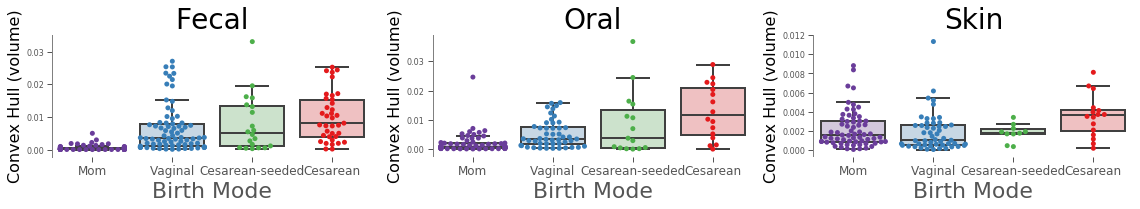

In [20]:
# colors
camp_ = {'Mom':'#6a3d9a',
         'Vaginal':'#377eb8',
         'Cesarean-seeded':'#4daf4a',
         'Cesarean':'#e41a1c'}
replace_ = {'Mom':'Mom',
           'Vag':'Vaginal',
           'CS':'Cesarean',
           'CSseed':'Cesarean-seeded'}
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': .1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 8

fig, axn = plt.subplots(1,3, figsize=(16, 3))

stypes = ['Feces','Mouth','Right_Forearm']
stypes_map = {'Feces':'Fecal',
              'Mouth':'Oral',
              'Right_Forearm':'Skin'}
for stype_, ax in zip(stypes, axn.flatten()):
    
    site_person_ch_tmp = site_person_ch[site_person_ch.body_site.isin([stype_])].copy()
    site_person_ch_tmp['bmode'] = site_person_ch_tmp.birth_mode.replace(replace_)
    sns.boxplot(data=site_person_ch_tmp,
                y='convexhull_volume',
                x='bmode',
                order=['Mom', 'Vaginal', 'Cesarean-seeded', 'Cesarean'],
                palette=camp_, ax=ax, showfliers=False)
    sns.swarmplot(data=site_person_ch_tmp,
                y='convexhull_volume',
                x='bmode',
                order=['Mom', 'Vaginal', 'Cesarean-seeded', 'Cesarean'],
                palette=camp_, ax=ax, dodge=True)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    ax.set_ylabel('Convex Hull (volume)',
                  fontsize=16,
                  color='black')
    ax.set_xlabel('Birth Mode',
                  fontsize=22)
    ax.set_title(stypes_map[stype_], fontsize=28)
    #ax.legend_.remove()
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')


plt.tight_layout()

#save
plt.savefig('../results/Figure-1b.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [22]:
import numpy as np 

stats_df = {}
for stype_ in stypes:
    # add stat annots
    order = ['Mom', 'Vag', 'CSseed', 'CS']
    site_person_ch_tmp = site_person_ch[site_person_ch.body_site.isin([stype_])].copy()
    order_map = {i:v for v, i in enumerate(order)}
    order_map = {v:tuple(order_map[v_] for v_ in v)
                 for v in list(itertools.combinations(order, 2))}
    order_stats = {k:list(ss.mannwhitneyu(site_person_ch_tmp[site_person_ch_tmp.birth_mode.isin([k[0]])].convexhull_volume,
                                     site_person_ch_tmp[site_person_ch_tmp.birth_mode.isin([k[1]])].convexhull_volume))
                   for k, v in order_map.items()}
    stat_tmp = pd.DataFrame(order_stats, ['test-stat','P']).T
    stats_df[stype_] = stat_tmp

stats_df = pd.concat(stats_df).reset_index()
stats_df.columns = ['body_type','g1','g2','test-stat','P']
stats_df['compare'] = stats_df['g1'] + ' vs. ' + stats_df['g2'] 
stats_df = stats_df.drop(['g1','g2'], axis=1)
stats_df = stats_df[['body_type','compare','test-stat','P']]
stats_df['P'] = stats_df['P'] * len(list(itertools.combinations(order, 2)))
stats_df['P'] = [str(v)[:4] + str(v)[str(v).index('e'):]
                 if v < .0001 else round(v, 3) for v in stats_df.P]
stats_df['test-stat'] = stats_df['test-stat'].astype(int)
stats_df.to_csv('../results/Extended-Data-Table-4.csv')
stats_df


,body_type,compare,test-stat,P
0,Feces,Mom vs. Vag,509,2.41e-17
1,Feces,Mom vs. CSseed,130,6.21e-08
2,Feces,Mom vs. CS,101,8.24e-15
3,Feces,Vag vs. CSseed,713,2.025
4,Feces,Vag vs. CS,901,0.006
5,Feces,CSseed vs. CS,285,0.473
6,Mouth,Mom vs. Vag,729,4.22e-06
7,Mouth,Mom vs. CSseed,326,0.142
8,Mouth,Mom vs. CS,138,1.80e-05
9,Mouth,Vag vs. CSseed,352,2.711
